In [1]:
from google.colab import drive
drive.mount('cnontent/')

Drive already mounted at cnontent/; to attempt to forcibly remount, call drive.mount("cnontent/", force_remount=True).


In [67]:
!pip install -q wandb

     |████████████████████████████████| 1.8 MB 14.4 MB/s 
     |████████████████████████████████| 181 kB 65.8 MB/s 
     |████████████████████████████████| 145 kB 46.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [68]:
import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
import os
import random
%matplotlib inline

In [3]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [4]:
ls

a.png                     mobile2
augmented_emnist.csv      Mobile_ELU_SGD_1000_120_005.h5
balanced_train_label.npy  Mobile_Leacky_SGD_800_100_05.h5
balanced_train.npy        Mobile_Leacky_SGD_800_100_05.h5_1/
balanced_val_label.npy    Mobile_ReLU_SGD_800_05.h5
balanced_val.npy          my_lenet5_emnist_model_20220515.h5
checkpoint                our_handmade_dataset.csv
emnist-byclass-test.csv   res_res_ckp/
emnist-byclass-train.csv  test_dataset_학점살려조.csv
images/                   wandb/


In [5]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [6]:
def balanced_data(data, label, border, n_train=1000, val_rate = 0.2):
  i, start=0,0
  d_train = l_train = d_val = l_val= None
  n_data_per_class = n_train
  n_val_per_class = int(n_data_per_class*val_rate)


  for idx, class_end in enumerate(border):
    if i ==0:
      val_end = n_data_per_class+n_val_per_class

      d_train = data[:n_data_per_class].copy()
      l_train = label[:n_data_per_class].copy()

      d_val = data[n_data_per_class:val_end].copy()
      l_val = label[n_data_per_class:val_end].copy()

      i+=1
    else:
      train_end = start+n_data_per_class
      val_end = train_end+n_val_per_class

      now_d_data = data[start:train_end].copy()
      now_l_train = label[start:train_end].copy()
      d_train = np.concatenate((d_train, now_d_data))
      l_train = np.concatenate((l_train, now_l_train))

      now_d_val = data[train_end:val_end].copy()
      now_l_val = label[train_end:val_end].copy()
      d_val = np.concatenate((d_val, now_d_val))
      l_val = np.concatenate((l_val, now_l_val))
    start += class_end
  return (d_train, l_train, d_val, l_val)

In [7]:
train_data = np.load('./balanced_train.npy')
train_label = np.load('./balanced_train_label.npy')
val_data = np.load('./balanced_val.npy')
val_label = np.load('./balanced_val_label.npy')

In [8]:
domain_train_label = np.array(train_label.copy())
domain_val_label = np.array(val_label.copy())

domain_train_label[domain_train_label<10] = 0
domain_train_label[(10<=domain_train_label)&(domain_train_label<36)] = 1
domain_train_label[36<=domain_train_label] = 2

domain_val_label[domain_val_label<10] = 0
domain_val_label[(10<=domain_val_label)&(domain_val_label<36)] = 1
domain_val_label[36<=domain_val_label] = 2

In [9]:
print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)

(62000, 28, 28, 1)
(62000,)
(12400, 28, 28, 1)
(12400,)


In [10]:
print(np.unique(domain_train_label))
print(np.unique(domain_val_label))

[0 1 2]
[0 1 2]


In [11]:
train_label = keras.utils.to_categorical(train_label)
val_label = keras.utils.to_categorical(val_label)

In [12]:
print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)

(62000, 28, 28, 1)
(62000, 62)
(12400, 28, 28, 1)
(12400, 62)


In [13]:
domain_train_label = keras.utils.to_categorical(domain_train_label)
domain_val_label = keras.utils.to_categorical(domain_val_label)

In [14]:
print(domain_train_label.shape)
print(domain_val_label.shape)

(62000, 3)
(12400, 3)


In [15]:
class ResnetBlock(keras.models.Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = keras.layers.Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = keras.layers.BatchNormalization()
        self.conv_2 = keras.layers.Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = keras.layers.BatchNormalization()
        self.merge = keras.layers.Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = keras.layers.Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = keras.layers.BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [118]:
class Res_5x5_v4(keras.models.Model):

    def __init__(self, num_classes, config_list, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)

        self.input_ch, self.activation, self.feature_layer_depth, self.domain_nueron, self.num_layer_nueron, self.upper_layer_nueron, self.lower_layer_nueron = config_list


        self.Global_Average_Pool_Layer = keras.layers.GlobalAveragePooling2D()
        self.Flatten_Layer = keras.layers.Flatten()

        self.Feature_Detection_Layer = self.feature_detection_layer()
        
        self.Domain_Layer = self.domain_layer()
        self.Number_Layer = self.number_layer()
        self.Upper_Letter_Layer = self.upper_letter_layer()
        self.Lower_Letter_Layer = self.lower_letter_layer()


        self.Prediction_Layer = keras.layers.Dense(num_classes, activation="softmax")

    def feature_detection_layer(self):
      feature_dec_layer = keras.models.Sequential()
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.Conv2D(self.input_ch, (5, 5), strides=1, padding="same", kernel_initializer="he_normal"))
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding="same"))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      
      for i in range(self.feature_layer_depth-1):
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1)), down_sample=True))
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1))))

      feature_dec_layer.add(self.Global_Average_Pool_Layer)
      feature_dec_layer.add(self.Flatten_Layer)


      return feature_dec_layer

    def domain_layer(self):
      num_layer = keras.models.Sequential(name = "domain_layer")
      for i, num_nueron in enumerate(self.domain_nueron):
        num_layer.add(tf.keras.layers.Dense(num_nueron))
        num_layer.add(self.select_activation(self.activation))
        num_layer.add(keras.layers.BatchNormalization())
    
      num_layer.add(tf.keras.layers.Dense(3, activation = 'softmax'))

      return num_layer

    def number_layer(self):
      num_layer = keras.models.Sequential(name = "number_layer")
      for i, num_nueron in enumerate(self.num_layer_nueron):
        num_layer.add(tf.keras.layers.Dense(num_nueron))
        num_layer.add(self.select_activation(self.activation))
        num_layer.add(keras.layers.BatchNormalization())
    
      num_layer.add(tf.keras.layers.Dense(10, activation = None))

      return num_layer

    def upper_letter_layer(self):
      upper_layer = keras.models.Sequential(name = "upper_layer")
      for i, num_nueron in enumerate(self.upper_layer_nueron):
        upper_layer.add(tf.keras.layers.Dense(num_nueron))
        upper_layer.add(self.select_activation(self.activation))
        upper_layer.add(keras.layers.BatchNormalization())

      upper_layer.add(tf.keras.layers.Dense(26, activation = None))
      return upper_layer

    def lower_letter_layer(self):
      lower_layer = keras.models.Sequential(name = "lower_layer")

      for i, num_nueron in enumerate(self.lower_layer_nueron):
        lower_layer.add(tf.keras.layers.Dense(num_nueron))
        lower_layer.add(self.select_activation(self.activation))
        lower_layer.add(keras.layers.BatchNormalization())

      lower_layer.add(tf.keras.layers.Dense(26, activation = None))
      return lower_layer

    def select_activation(self, function):
      if function == 'relu':
        activation = keras.layers.ReLU()
      elif function == 'prelu':
        activation = keras.layers.PReLU()
      elif function == 'leacky_relu':
        activation = keras.layers.LeakyReLU()
      elif function == 'elu':
        activation = keras.layers.ELU()
      else:
        activation = keras.layers.ReLU()
      return activation

In [119]:
def select_model(config_list):
  model_class = Res_5x5_v4(64, config_list)

  input = keras.layers.Input(shape=(28, 28, 1), name = "input_layer")

  feature_out = model_class.Feature_Detection_Layer(input)

  domain_result = model_class.Domain_Layer(feature_out)
  domain_weight = domain_result[0]

  num_out = model_class.Number_Layer(feature_out)
  upper_out = model_class.Upper_Letter_Layer(feature_out)
  lower_out = model_class.Lower_Letter_Layer(feature_out)

  weighted_num = num_out*domain_weight[0]
  weighted_upper = upper_out*domain_weight[1]
  weighted_lower = lower_out*domain_weight[2]


  final_out = keras.layers.concatenate([weighted_num, weighted_upper, weighted_lower])
  result = tf.keras.layers.Softmax(name = 'final_classification')(final_out)

  model = keras.models.Model(inputs=[input], outputs=[domain_result, result])
  return model

In [121]:
test = [64, 'relu', 2, [50], [100, 50], [200, 100 , 50], [100, 50]]

In [122]:
test_model = select_model(test)

In [123]:
test_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 128)          678148      ['input_layer[0][0]']            
                                                                                                  
 domain_layer (Sequential)      (None, 3)            6803        ['sequential_3[0][0]']           
                                                                                                  
 tf.__operators__.getitem_68 (S  (3,)                0           ['domain_layer[0][0]']           
 licingOpLambda)                                                                            

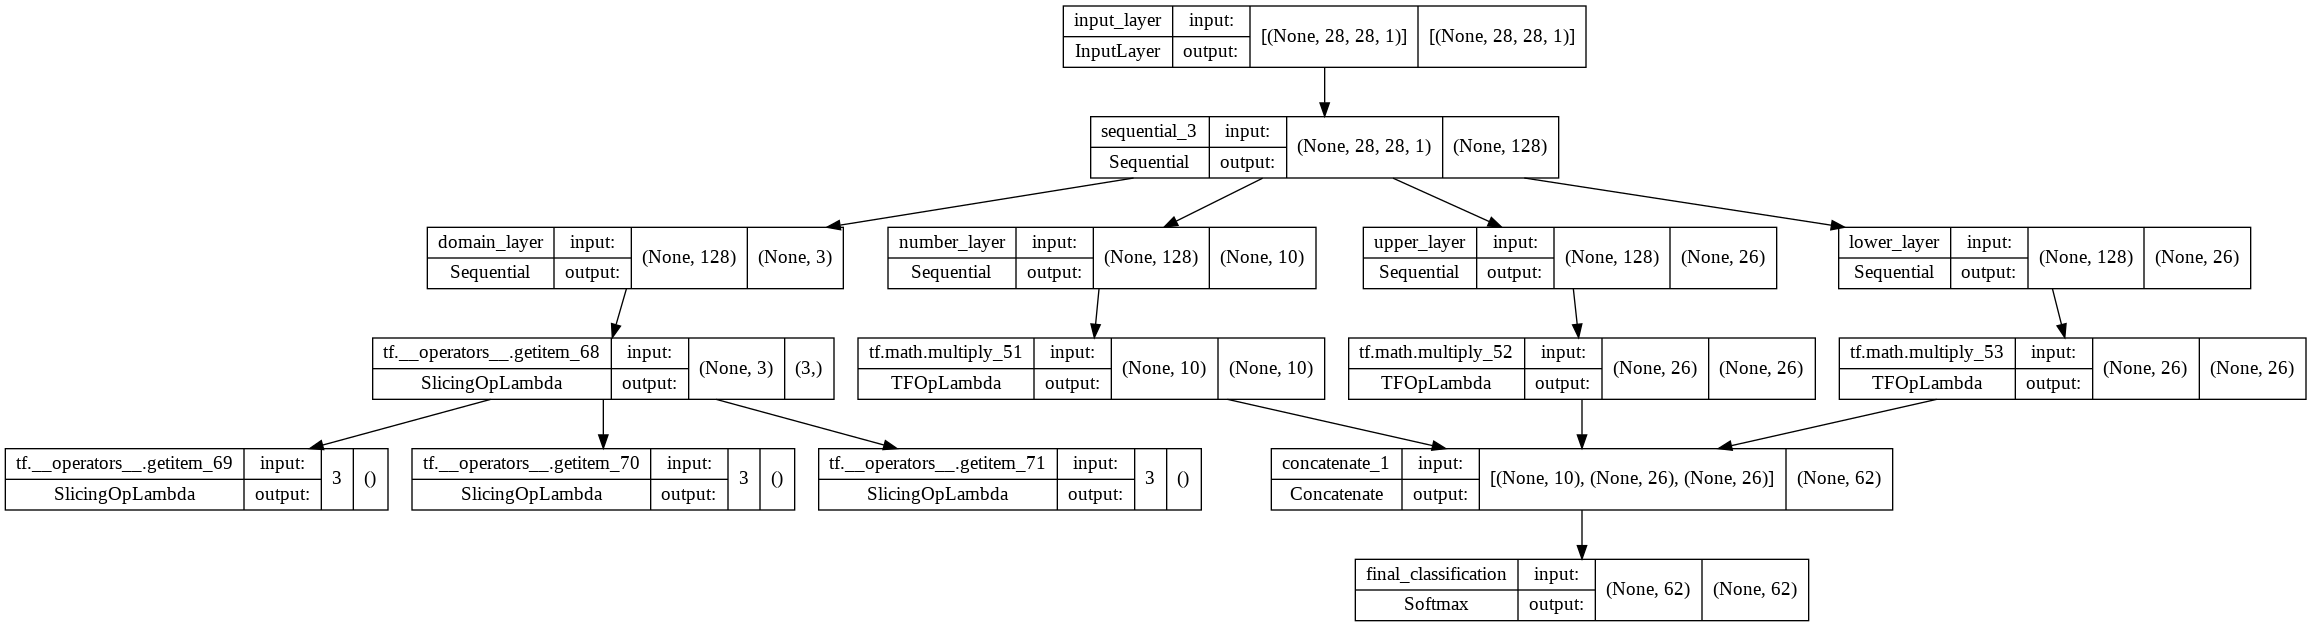

In [124]:
keras.utils.plot_model(test_model, "a.png", show_shapes=True)

In [125]:
def custom_loss(y_true, y_pred):
  # import time
  loss = []
  for true, pred in zip(y_true, y_pred):
    t = np.argmax(true)
    p = np.argmax(pred)
    t_domain, p_domain = None, None

    if t<10:
      t_domain = 0
    elif 10<=t and t<36:
      t_domain = 1
    elif 36<=t:
      t_domain = 2

    if p<10:
      p_domain = 0
    elif 10<=p and p<36:
      p_domain = 1
    elif 36<=p:
      p_domain = 2

    if t_domain != p_domain:
      now_loss = 0
    else:
      now_loss = tf.keras.losses.CategoricalCrossentropy()(true, pred)

    loss.append(now_loss)
  loss = tf.convert_to_tensor(loss, dtype=tf.float32)
  # print(loss)
  # time.sleep(3)
  return loss

In [126]:
loss_func = tf.keras.losses.CategoricalCrossentropy()([0, 0, 0, 1, 0],[0.2, 0.3, 0.2, 0.2, 0.1])
print(loss_func)

tf.Tensor(1.609438, shape=(), dtype=float32)


In [129]:
test_model.compile(loss=["categorical_crossentropy", custom_loss],
                   loss_weights=[0.4, 0.6], optimizer='adam', metrics=["accuracy" ], run_eagerly=True)

In [130]:
test_history = test_model.fit(train_data, [domain_train_label, train_label], epochs = 10,
                              validation_data = (val_data, [domain_val_label, val_label]))

In [68]:
print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)

In [70]:
def select_opt(opt_name, lr):
  if opt_name == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
  elif opt_name == 'sgd':
    optimizer = keras.optimizers.SGD(learning_rate = lr)
  elif opt_name == 'momentum':
    optimizer = keras.optimizers.SGD(learning_rate = lr, momentum=0.9)
  elif opt_name == 'nesterov':
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
  elif opt_name == 'adagrad':
    optimizer = keras.optimizers.Adagrad(learning_rate=lr)
  elif opt_name == 'adamax':
    optimizer = keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'nadam':
    optimizer = keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

  return optimizer

In [69]:
def get_layer_nueron_list(channel, num_feature_layer ,num_layer, num_out_nueron):
  num_input = channel*num_feature_layer
  nueron_list = []
  interval = (num_input-num_out_nueron)//(num_layer+1)
  criterion = num_input
  for i in range(num_layer):
    criterion -= interval
    nueron_list.append(criterion)
  return nueron_list

In [80]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
# val_domain_layer_accuracy: 0.4708 - val_final_classification_accuracy:
    def on_epoch_end(self, epoch, logs=None):
        print(f'''
              epcoh : {epoch}
              val_domain_layer_accuracy {logs['val_domain_layer_accuracy']}
              val_final_classification_accuracy {logs['val_final_classification_accuracy']}
              ''')
        wandb.log({'epochs': epoch,
            'val_domain_layer_accuracy': logs['val_domain_layer_accuracy'],
            'val_final_classification_accuracy': logs['val_final_classification_accuracy']
            })

In [114]:
def sweep_train(config_defaults=None):
    # Set default values

    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='final_classification_accuracy', patience=5, restore_best_weights=True)

    config_defaults = {
      'channel' : 32,
      'batch_size': 64,
      'activation': 'relu',
      'optimizer' : 'adam',
      'learning_rate' : 0.01,
      'feature_layer_depth' : 2,
      'domain_layer_depth' : 2,
      'num_layer_depth' : 2,
      'upper_layer_depth' : 2,
      'lower_layer_depth' : 2,
      'domain_loss_rate' : 0.5
    }
    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    last_neuron_perlayer = [3, 10, 26, 26]
    num_dense_per_layer = [wandb.config.domain_layer_depth, wandb.config.num_layer_depth, wandb.config.upper_layer_depth, wandb.config.lower_layer_depth]
    num_flatten_layer = wandb.config.channel * wandb.config.feature_layer_depth
    nueron_list = []

    for last_nueron, num_dense in zip(last_neuron_perlayer, num_dense_per_layer):
      now_layer_nueron = []
      boundary = (num_flatten_layer - last_nueron)//(num_dense+1)
      now_nueron = num_flatten_layer
      for i in range(num_dense):
        now_nueron -= boundary
        now_layer_nueron.append(now_nueron)
      nueron_list.append(now_layer_nueron)

    print(nueron_list)

    # initialize model

    # test = [64, 'relu', 2, [50], [100, 50], [200, 100 , 50], [100, 50]]

    config_list = [
                    wandb.config.channel, wandb.config.activation, wandb.config.feature_layer_depth, 
                    nueron_list[0], nueron_list[1], nueron_list[2], nueron_list[3]
                   ]
    model = select_model(config_list)
    optimizer = select_opt(wandb.config.optimizer, wandb.config.learning_rate)
    loss_rate = [wandb.config.domain_loss_rate , 1-wandb.config.domain_loss_rate]
    print(loss_rate)
    
    print(model.summary())

    # Instantiate an optimizer to train the model.


    model.compile(loss=["categorical_crossentropy", custom_loss], loss_weights=loss_rate,
                
                  optimizer=optimizer,

                  metrics=["accuracy",],
                   run_eagerly=True
                  )
    
    hist = model.fit(train_data, [domain_train_label, train_label], epochs=50, 
                     validation_data=(val_data, [domain_val_label, val_label]), callbacks=[early_stopping_cb, LossAndErrorPrintingCallback()])

In [115]:
sweep_config = {
  'method': 'random', 
  'parameters': {
      
      'channel': {
          'values' : [16, 32]
      },
      'optimizer': {
          'values' : ['adam', 'rmsprop', 'sgd', 'momentum', 'nesterov', 'adagrad', 'adamax', 'nadam']
      },
      'learning_rate':{
          'values' : [0.1, 0.05, 0.01, 0.005]
      },
      'feature_layer_depth' : {
          'values' : [1, 2, 3]
      },
      'domain_layer_depth' : {
          'values' : [1, 2]
      },
      'num_layer_depth' : {
          'values' : [1, 2]
      },
      'upper_layer_depth' : {
          'values' : [1, 2]
      },
      'lower_layer_depth' : {
          'values' : [1, 2]
      },
      'activation' : {
          'values' : ['relu', 'leacky_relu', 'elu']
      },
      'domain_loss_rate' : {
          'values' : [0.3, 0.4, 0.5, 0.6]
      }
  }
}

In [106]:
sweep_id = wandb.sweep(sweep_config, project="weighted_res_dense_2")

Create sweep with ID: js9vk0ib
Sweep URL: https://wandb.ai/chanin-eom/weighted_res_dense_2/sweeps/js9vk0ib


In [116]:
wandb.agent(sweep_id, function=sweep_train, count=50)

wandb: Agent Starting Run: 5qderyuh with config:
wandb: 	activation: relu
wandb: 	channel: 16
wandb: 	domain_layer_depth: 3
wandb: 	domain_loss_rate: 0.5
wandb: 	feature_layer_depth: 3
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 3
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adam
wandb: 	upper_layer_depth: 3


[[37, 26, 15], [29], [43, 38, 33], [43, 38, 33]]
[0.5, 0.5]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           176260      ['input_layer[0][0]']            
                                                                                                  
 domain_layer (Sequential)      (None, 3)            4158        ['sequential[0][0]']             
                                                                                                  
 tf.__operators__.getitem_64 (S  (3,)                0           ['domain_layer[0][0]']           
 licingOpLambda)                  

wandb: Ctrl + C detected. Stopping sweep.
